In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


# Importing Dependencies

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow version", tf.__version__)

2025-03-08 19:20:35.395462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-08 19:20:35.395602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-08 19:20:35.531261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow version 2.15.0


In [3]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', 
                 encoding = 'latin',header=None)
                
df.sample(6).style.set_properties(**{'background-color': '#f9f9f9', 'color': 
                                     '#4CAF50', 'font-weight': 'bold'})

,0,1,2,3,4,5
1368641,4,2050640686,Fri Jun 05 19:02:05 PDT 2009,NO_QUERY,Raynalin,"@arian_marie gosh I miss Jerz, i moved up here w/ my soilder hubby! How was sandbar? Jerz likes 2 act all cool but they know they love u!"
174086,0,1964330414,Fri May 29 14:04:04 PDT 2009,NO_QUERY,lovestars96xx,@mileycyrus why you never answer me...
259760,0,1985513150,Sun May 31 17:14:52 PDT 2009,NO_QUERY,NAYKIDD,"i miss @jocelynbrooks @ayekaygee. def miss @loveashlay, been months! lol and @cosmodoll even tho she never wants to hang"
54068,0,1680909647,Sat May 02 12:46:39 PDT 2009,NO_QUERY,shirizaan,@Gundampilotspaz Oh boo. I play on the 360.
1318810,4,2014411533,Wed Jun 03 01:26:31 PDT 2009,NO_QUERY,Tonange,@thedreamgirl123 thank u for following me I added u 2 I loved the background of ur page!
245981,0,1982134930,Sun May 31 10:35:51 PDT 2009,NO_QUERY,TimMothE,@truejerseygirl You too! Enjoy your FREEDOM!!! I wish I didn't have to study.


In [4]:
#Giving names to the Columns
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
              
df.head().style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [5]:
#We only need text to train to classify sentiment so we will drop other columns
df = df.drop( ['id', 'date', 'query', 'user_id'], axis = 1)

In [6]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
    return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x : label_decoder(x))
df.head().style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


We have decoded the labels 0 ---> Negative and 1---> Positive as directed by the dataset description. Now we will analyse the dataset for its distribution.

Text(0.5, 1.0, 'Sentiment Data Distribution')

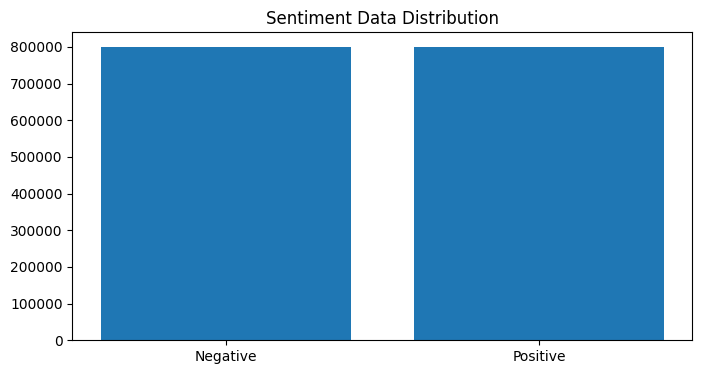

In [7]:
val_counts = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_counts.index, val_counts.values)
plt.title("Sentiment Data Distribution")

Its a very good Dataset without any skewness.
Now let is explore the data we have

In [8]:
import random
random_idx_list = [random.randint(1, len(df.text)) for i in range(10)] # Creates random indexes to choose from  dataframe
df.loc[random_idx_list, :].head(10).style.set_properties(**{'background-color' :'#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'}) #Returns the row with indexes and displays it

,sentiment,text
486668,Negative,@ehawes1 What bout me?
540560,Negative,is are still sad about Duke Nukem Forever being canceled http://ping.fm/Udshc
128787,Negative,AAAAAAAAAAAAAAARRRRRRRRRRRRGHHHHHHHHH!!!! I am clearly going to fail this exam.....
1496946,Positive,@jonghwoo Maybe i should drink couple beers then!!
82633,Negative,@TC_Chavez : Bummer
911308,Positive,Be my Yoko Ono and follow me wherever I may go !
418322,Negative,Oh...I should eat a pony.
518588,Negative,H as h today Downside of being s again
1231769,Positive,@AlyGreen @lizgreenberg You should check out the live webcast for #NF09 http://www.digitalcontentnewfront.com/schedule/ #internetweek
653934,Negative,@aamwilliams no I still have 6 months on 3G contract left


The Data has alot of punctuations that are words that we use without any contextual meaning. So we need to get rid of it.

# Text Preprocessing

Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model. We cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods. 

*Stemming / Lematization / Stopwords*

In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
df.text = df.text.apply(lambda x :preprocess(x))

The data is clean & tidy. Now lets see the word cloud visualization of it.

**Positive Words**

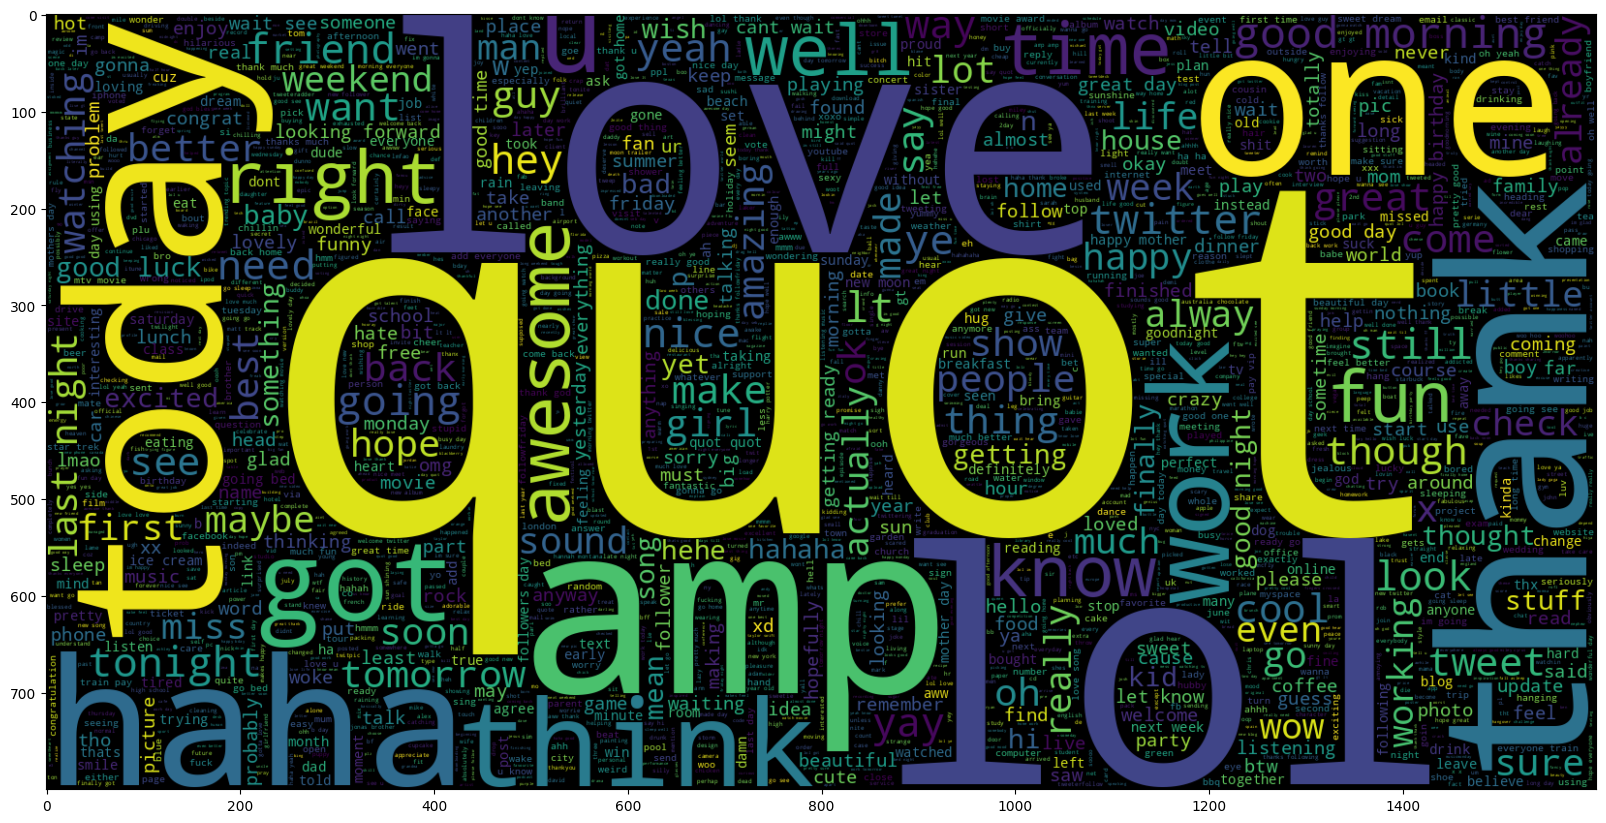

In [12]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc =  WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc, interpolation = 'bilinear')

**Negative Words**

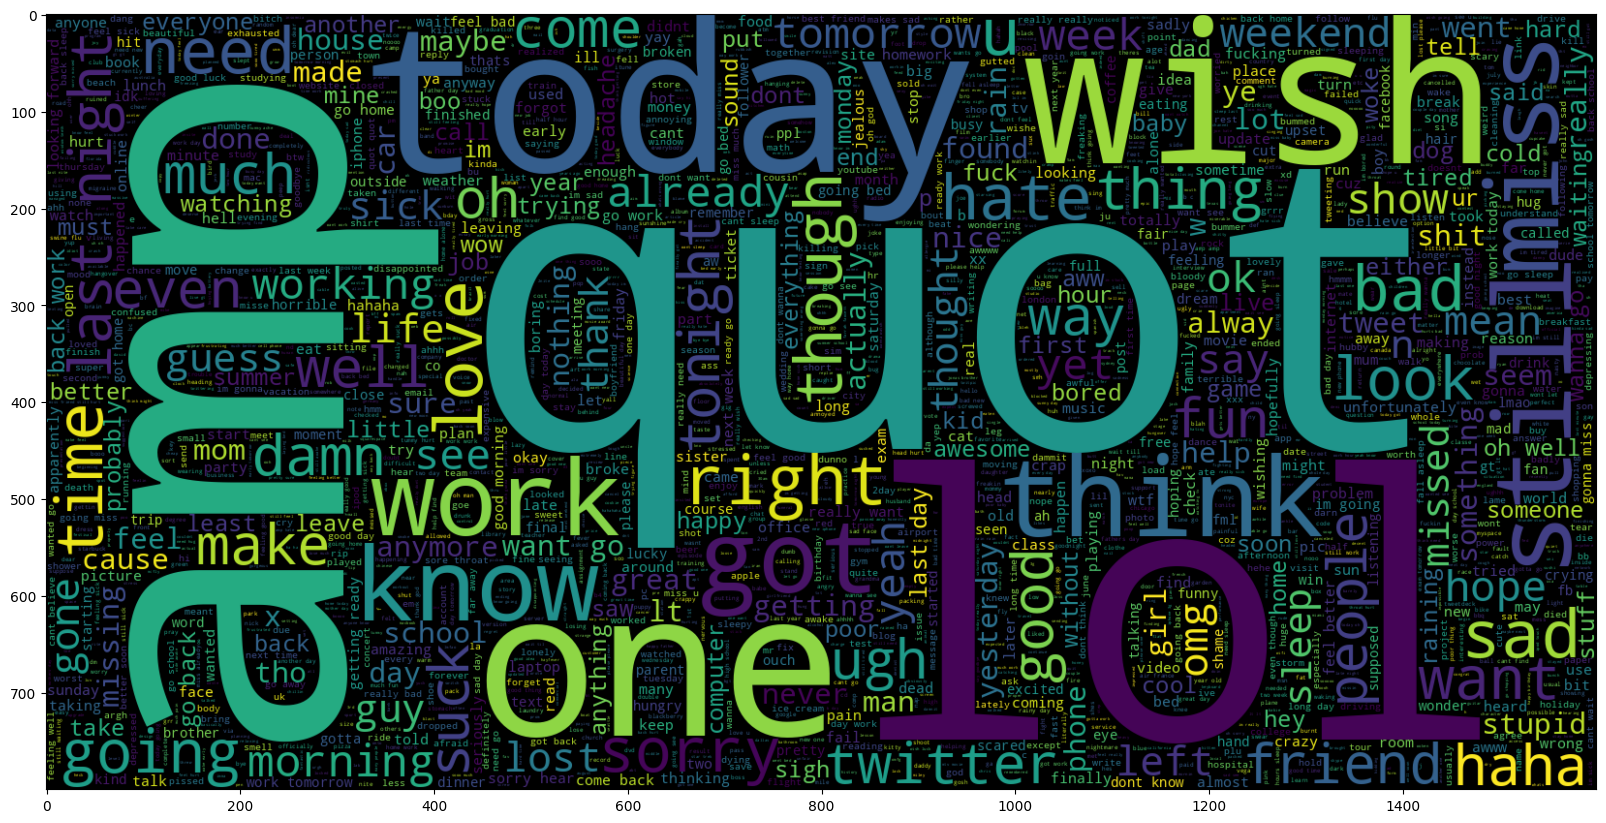

In [13]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc =  WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc, interpolation = 'bilinear')

# Train and Test Split

In [14]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [15]:
train_data, test_data =  train_test_split(df, test_size = 1-TRAIN_SIZE, random_state = 7) #Splits Dataset intro Training and Testing set

print("Train Data size:", len(train_data))
print("Test Data size:", len(test_data))

Train Data size: 1280000
Test Data size: 320000


train_test_split will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [16]:
train_data.sample(10).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'}) # Returns the rows with the index and display it

,sentiment,text
1019633,Positive,hoping today better forget phone
490702,Negative,think head going explode
1234908,Positive,apple uses new samsung amoled screens iphone leave everything else dust
131529,Negative,good morning monday ugh
190255,Negative,erinhere javits tomorrow must meet make tweetup
1034440,Positive,happy birthday 5 4 3 2 1
45408,Negative,fat joe witnessed falling stairs right thigh hurts goodnight
684345,Negative,boo lameness
1172790,Positive,oh shit getlive buggin dolores naaa cool right tell em get rane 57 ssl installed built
654307,Negative,morning jess crept outta work get damn eyebrows waxed taking forever big mama damn


**Tokenization**

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. The process is called Tokenization.

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

Vocabulary size: 290575


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                      maxlen =  MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), 
                     maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:", x_train.shape)
print("Testing X Shape:", x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [19]:
labels = train_data.sentiment.unique().tolist()

**Label Encoding**

We are building the model to predict class in encoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings

In [20]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train_shape:", y_train.shape)
print("y_test_shape:", y_test.shape)

y_train_shape: (1280000, 1)
y_test_shape: (320000, 1)


Word Embedding

In this notebook, I use GloVe Embedding from Stanford AI which can be found [HERE](https://nlp.stanford.edu/projects/glove/)

In [21]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2025-03-08 19:24:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-08 19:24:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-08 19:24:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [22]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 50
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [23]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [24]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Model Training LSTM** 

In [26]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [27]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [28]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 30, 300)        │    87,172,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 30, 300)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 26, 64)         │        96,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,663,829 (334.41 MB)

 Trainable params: 491,329 (1.87 MB)

 Non-trainable params: 87,172,500 (332.54 MB)

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [30]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


In [31]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 60ms/step - accuracy: 0.7151 - loss: 0.5488 - val_accuracy: 0.7645 - val_loss: 0.4834 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.7576 - loss: 0.4951 - val_accuracy: 0.7723 - val_loss: 0.4727 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 73s 59ms/step - accuracy: 0.7655 - loss: 0.4834 - val_accuracy: 0.7750 - val_loss: 0.4679 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 73s 59ms/step - accuracy: 0.7700 - loss: 0.4759 - val_accuracy: 0.7774 - val_loss: 0.4643 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.7728 - loss: 0.4715 - val_accuracy: 0.7779 - val_loss: 0.4626 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.7742 - loss: 0.4685 - val_accuracy: 0.7797 - val_loss: 0.4613 - learning_rate: 0.0010
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 60ms/step - accura

# Model Evaluation 

Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

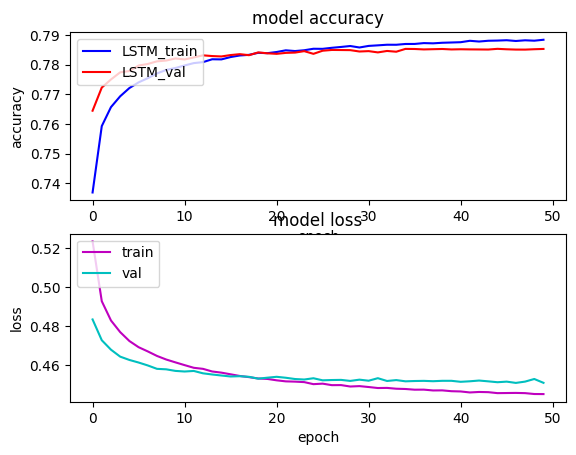

In [32]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as POSITIVE sentiment.

In [33]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step


# Confusion Matrix 

Confusion Matrix provide a nice overlook at the model's performance in classification task

In [34]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

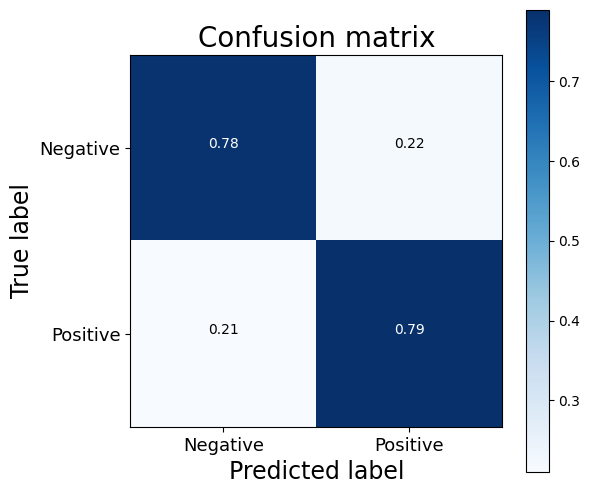

In [35]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

# Classification Score

In [36]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.78      0.79    160542
    Positive       0.78      0.79      0.79    159458

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



It's a pretty good model we trained here in terms of NLP. Around 80% accuracy is good enough considering the baseline human accuracy also pretty low in these tasks. Also, you may go on and explore the dataset, some tweets might have other languages than English. So our Embedding and Tokenizing wont have effect on them. But on practical scenario, this model is good for handling most tasks for Sentiment Analysis.
